# Example 1 (FastBNB)

This notebook shows predictions for nueCCQE-like events at MiniBooNE using the "fastbnb" module -- installed separately from:

[github.com/mhostert/MiniBooNE-DarkNews](https://github.com/mhostert/MiniBooNE-DarkNews)

We first explore the analyses methods themselves. For more infor, see [this paper](https://arxiv.org/abs/2308.02543).

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

try:
    from importlib.resources import files
except ImportError:
    from importlib_resources import files

import DarkNews as dn
from DarkNews import GenLauncher
from DarkNews import Cfourvec as Cfv
from DarkNews import plot_tools as pt


In [8]:
import fastbnb # (https://github.com/mhostert/MiniBooNE-DarkNews)


### Generate events for MiniBooNE FHC

In [9]:
common_kwargs={'loglevel': 'WARNING', 'HNLtype': 'dirac', 'neval': 1e4, 'experiment': 'miniboone_fhc'}

In [10]:
kwargs_1={'m5': 0.150, 'm4': 0.001, 'mzprime': 0.03,'Umu5': 3.5e-5, 'Umu4': 2.5e-5, 'epsilon': 1e-3, 'path': 'data/example_1'}
kwargs_2={'m5': 0.200, 'm4': 0.001, 'mzprime': 0.150,'Umu5': 3.5e-5, 'Umu4': 2.5e-5, 'epsilon': 1e-3, 'path': 'data/example_2'}
kwargs_3={'m5': 0.400, 'm4': 0.001, 'mzprime': 0.200,'Umu5': 3.5e-5, 'Umu4': 2.5e-5, 'epsilon': 1e-3, 'path': 'data/example_3'}

df_1 = GenLauncher(**kwargs_1, **common_kwargs).run()
df_2 = GenLauncher(**kwargs_2, **common_kwargs).run()
df_3 = GenLauncher(**kwargs_3, **common_kwargs).run()

kwargs_4={'m5': 0.150, 'm4': 0.001, 'mzprime': 1.25,'Umu5': 3.5e-5, 'Umu4': 2.5e-5, 'epsilon': 1e-3, 'path': 'data/example_4'}
kwargs_5={'m5': 0.200, 'm4': 0.001, 'mzprime': 1.25,'Umu5': 3.5e-5, 'Umu4': 2.5e-5, 'epsilon': 1e-3, 'path': 'data/example_5'}
kwargs_6={'m5': 0.400, 'm4': 0.001, 'mzprime': 1.25,'Umu5': 3.5e-5, 'Umu4': 2.5e-5, 'epsilon': 1e-3, 'path': 'data/example_6'}

df_4 = GenLauncher(**kwargs_4, **common_kwargs).run()
df_5 = GenLauncher(**kwargs_5, **common_kwargs).run()
df_6 = GenLauncher(**kwargs_6, **common_kwargs).run()

Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.


# Decay selection

We take the DarkNews events, pass them through a decay selection code that reweights the "w_event_rate" weights based on the probability that N5 decays inside the fiducial volume of the detector. This only affects "w_event_rate". The original weights can be accessed in "w_pre_decay".

* df_decay_i['w_event_rate'] --- reweighted.
* df_decay_1['w_pre_decay'] --- original weights.

**NOTE**:  Since we do not monte-carlo the decay probability, "pos_decay" is not physical as the decay could have happened anywhere inside the fiducial volume. This method is faster and more efficient for long-lifetimes, but it does not determine a fixed decay position. We assign a dummy value for pos_decay based on the average position between the start and the end of the fiducial volume, but this is only a placeholder and does not constitute the actual position of the decay.

In [6]:
df_decay_1 = fastbnb.decayer.decay_selection(df_1, l_decay_proper_cm=df_1.attrs['N5_ctau0'], experiment='miniboone')
df_decay_2 = fastbnb.decayer.decay_selection(df_2, l_decay_proper_cm=df_2.attrs['N5_ctau0'], experiment='miniboone')

In [7]:
# %%prun
df_decay_3 = fastbnb.decayer.decay_selection(df_3, l_decay_proper_cm=df_3.attrs['N5_ctau0'], experiment='miniboone')
df_decay_4 = fastbnb.decayer.decay_selection(df_4, l_decay_proper_cm=df_4.attrs['N5_ctau0'], experiment='miniboone')

In [8]:
# %%prun
df_decay_5 = fastbnb.decayer.decay_selection(df_5, l_decay_proper_cm=df_5.attrs['N5_ctau0'], experiment='miniboone')
df_decay_6 = fastbnb.decayer.decay_selection(df_6, l_decay_proper_cm=df_6.attrs['N5_ctau0'], experiment='miniboone')

# Signal selection

The fiducialized events are then put through our simplified MiniBooNE signal selection. Only events compatible with the MiniBooNE nueCCQE events remain.

The signal selection follows one of the following methods:
        
        *   'circ1' picks events based on Kelly&Kopp criteria: 
                r = sqrt( (1 - CosTheta)^2/4 + (1 - Emax/Etot)^2 )
        *   'circ0' picks events based on Kelly&Kopp criteria: 
                r = sqrt( (1 + CosTheta)^2/4 + (Emax/Etot)^2 )
        *   'diag' picks events based on Kelly&Kopp criteria: 
                r = 1 - 1/2*((1 + CosTheta)/2 + Emax/Etot)
        *   'invmass' picks events based on invmass criteria from Patterson, assuming m_ee is correctly reconstructed.


The resulting dataframe (df_analysis_i) contains a new column: "reco_w", which is the weight of the evets after signal selection. If a given event does not pass the criteria, its weight is 0. For events that do pass the criteria, the weights are multiplied by the MiniBooNE efficiency.

In [9]:
df_analysis_1   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_1, cut='circ1')
df_analysis_2   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_2, cut='circ1')
df_analysis_3   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_3, cut='circ1')
df_analysis_4   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_4, cut='circ1')
df_analysis_5   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_5, cut='circ1')
df_analysis_6   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_6, cut='circ1')

In [10]:
df_analysis_1_circ0   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_1, cut='circ0')
df_analysis_1_diag   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_1, cut='diag')
df_analysis_1_invmass   = fastbnb.analysis.reco_nueCCQElike_Enu(df_decay_1, cut='invmass')

/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


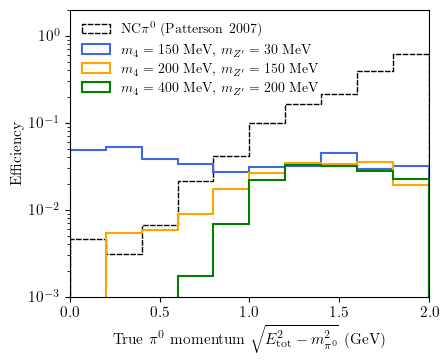

In [11]:
fig, ax = pt.std_fig()

VAR_1 = np.sqrt((df_analysis_1['P_decay_ell_plus','0'] + df_analysis_1['P_decay_ell_minus','0'])**2 - 0.135**2)
VAR_2 = np.sqrt((df_analysis_2['P_decay_ell_plus','0'] + df_analysis_2['P_decay_ell_minus','0'])**2 - 0.135**2)
VAR_3 = np.sqrt((df_analysis_3['P_decay_ell_plus','0'] + df_analysis_3['P_decay_ell_minus','0'])**2 - 0.135**2)
VAR_4 = np.sqrt((df_analysis_4['P_decay_ell_plus','0'] + df_analysis_4['P_decay_ell_minus','0'])**2 - 0.135**2)
VAR_5 = np.sqrt((df_analysis_5['P_decay_ell_plus','0'] + df_analysis_5['P_decay_ell_minus','0'])**2 - 0.135**2)
VAR_6 = np.sqrt((df_analysis_6['P_decay_ell_plus','0'] + df_analysis_6['P_decay_ell_minus','0'])**2 - 0.135**2)

ALPHA = 0.3
LW = 1.5

bins = np.linspace(0.0, 2.0, 11, endpoint=True)
binc = (bins[:-1]+bins[1:])/2
patterson_eff = np.genfromtxt(files('fastbnb.include.Patterson_tools').joinpath('pi0_nueCCQE_eff.dat').open())
ax.hist(binc, bins= bins, weights=patterson_eff, histtype='step', color='black', ls=(1,(4,1)), label=fr'NC$\pi^0$ (Patterson 2007)')

hist_1_t, _ = np.histogram(VAR_1, bins = bins, weights = df_analysis_1['w_event_rate']/df_analysis_1['w_event_rate'].sum())
hist_2_t, _ = np.histogram(VAR_2, bins = bins, weights = df_analysis_2['w_event_rate']/df_analysis_2['w_event_rate'].sum())
hist_3_t, _ = np.histogram(VAR_3, bins = bins, weights = df_analysis_3['w_event_rate']/df_analysis_3['w_event_rate'].sum())

hist_1, _ = np.histogram(VAR_1, bins = bins, weights = df_analysis_1['reco_w']/df_analysis_1['w_event_rate'].sum())
hist_2, _ = np.histogram(VAR_2, bins = bins, weights = df_analysis_2['reco_w']/df_analysis_2['w_event_rate'].sum())
hist_3, _ = np.histogram(VAR_3, bins = bins, weights = df_analysis_3['reco_w']/df_analysis_3['w_event_rate'].sum())


eps_1 = df_analysis_1['reco_w'].sum()/df_analysis_1['w_event_rate'].sum()
eps_2 = df_analysis_2['reco_w'].sum()/df_analysis_2['w_event_rate'].sum()
eps_3 = df_analysis_3['reco_w'].sum()/df_analysis_3['w_event_rate'].sum()

_ = ax.hist(binc, bins=bins, weights=hist_1/(hist_1_t+1e-6), histtype='step', edgecolor='royalblue', lw=LW, label=r'$m_4 = 150$~MeV, $m_{Z^\prime} = 30$~MeV')
_ = ax.hist(binc, bins=bins, weights=hist_2/(hist_2_t+1e-6), histtype='step', edgecolor='orange', lw=LW, label=r'$m_4 = 200$~MeV, $m_{Z^\prime} = 150$~MeV')
_ = ax.hist(binc, bins=bins, weights=hist_3/(hist_3_t+1e-6), histtype='step', edgecolor='green', lw=LW, label=r'$m_4 = 400$~MeV, $m_{Z^\prime} = 200$~MeV')

ax.legend(loc='upper left', ncol=1, fontsize=10)
ax.set_xlabel(r'True $\pi^0$ momentum $\sqrt{E_{\rm tot}^2 - m_{\pi^0}^2}$ (GeV)')
ax.set_ylabel(r'Efficiency')
ax.set_xlim(0, max(bins))
ax.set_ylim(1e-3, 2)
ax.set_yscale('log')

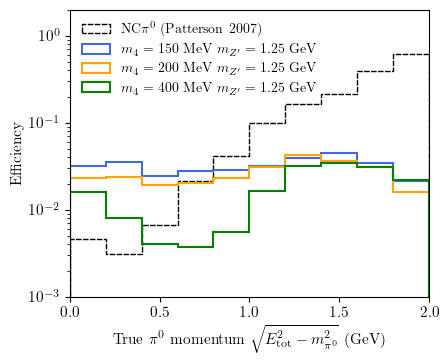

In [13]:
fig, ax = pt.std_fig()

bins = np.linspace(0.0, 2.0, 11, endpoint=True)
binc = (bins[:-1]+bins[1:])/2
patterson_eff = np.genfromtxt(files('fastbnb.include.Patterson_tools').joinpath('pi0_nueCCQE_eff.dat').open())
ax.hist(binc, bins= bins, weights=patterson_eff, histtype='step', color='black', ls=(1,(4,1)), label=fr'NC$\pi^0$ (Patterson 2007)')

hist_4_t, _ = np.histogram(VAR_4, bins = bins, weights = df_analysis_4['w_event_rate']/np.sum(df_analysis_4['w_event_rate']))
hist_5_t, _ = np.histogram(VAR_5, bins = bins, weights = df_analysis_5['w_event_rate']/np.sum(df_analysis_5['w_event_rate']))
hist_6_t, _ = np.histogram(VAR_6, bins = bins, weights = df_analysis_6['w_event_rate']/np.sum(df_analysis_6['w_event_rate']))
hist_4, _ = np.histogram(VAR_4, bins = bins, weights = df_analysis_4['reco_w']/np.sum(df_analysis_4['w_event_rate']))
hist_5, _ = np.histogram(VAR_5, bins = bins, weights = df_analysis_5['reco_w']/np.sum(df_analysis_5['w_event_rate']))
hist_6, _ = np.histogram(VAR_6, bins = bins, weights = df_analysis_6['reco_w']/np.sum(df_analysis_6['w_event_rate']))

eps_4 = df_analysis_4['reco_w'].sum()/df_analysis_4['w_event_rate'].sum()
eps_5 = df_analysis_5['reco_w'].sum()/df_analysis_5['w_event_rate'].sum()
eps_6 = df_analysis_6['reco_w'].sum()/df_analysis_6['w_event_rate'].sum()

_ = ax.hist(binc, bins = bins, weights=hist_4/hist_4_t, histtype='step', edgecolor='royalblue', lw=LW, label=r'$m_4 = 150$~MeV $m_{Z^\prime} = 1.25$~GeV')
_ = ax.hist(binc, bins = bins, weights=hist_5/hist_5_t, histtype='step', edgecolor='orange', lw=LW, label=r'$m_4 = 200$~MeV $m_{Z^\prime} = 1.25$~GeV')
_ = ax.hist(binc, bins = bins, weights=hist_6/hist_6_t, histtype='step', edgecolor='green', lw=LW, label=r'$m_4 = 400$~MeV $m_{Z^\prime} = 1.25$~GeV')

ax.legend(loc='upper left', ncol=1, fontsize=10)
ax.set_xlabel(r'True $\pi^0$ momentum $\sqrt{E_{\rm tot}^2 - m_{\pi^0}^2}$ (GeV)')
ax.set_ylabel(r'Efficiency')
ax.set_xlim(0, max(bins))
ax.set_ylim(1e-3, 2)
ax.set_yscale('log')

#### In reco variables

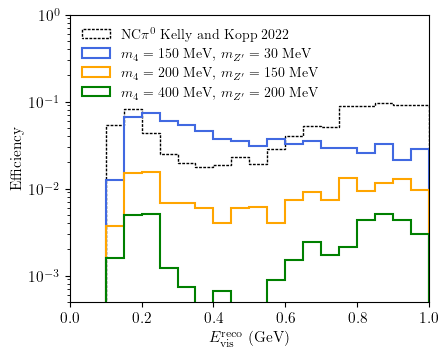

In [14]:
fig, ax = pt.std_fig()

VAR_1 = df_analysis_1['reco_Evis']
VAR_2 = df_analysis_2['reco_Evis']
VAR_3 = df_analysis_3['reco_Evis']
VAR_4 = df_analysis_4['reco_Evis']
VAR_5 = df_analysis_5['reco_Evis']
VAR_6 = df_analysis_6['reco_Evis']

bins = np.linspace(0.0, 1.0, 21, endpoint=True)
binc = (bins[:-1]+bins[1:])/2

kelly_bins = np.linspace(0.0, 1.0, 21, endpoint=True)
kelly_circ1_eff = np.genfromtxt(files('fastbnb.include.pi0_tools').joinpath('pi0_efficiency_circ1.dat').open())
ax.hist(kelly_circ1_eff[:,0], bins= kelly_bins, weights=kelly_circ1_eff[:,1], histtype='step', color='black', ls=(1,(2,1)), label=fr'NC$\pi^0$ Kelly and Kopp 2022')

hist_1_t, _ = np.histogram(VAR_1, bins = bins, weights = df_analysis_1['w_event_rate']/df_analysis_1['w_event_rate'].sum())
hist_2_t, _ = np.histogram(VAR_2, bins = bins, weights = df_analysis_2['w_event_rate']/df_analysis_2['w_event_rate'].sum())
hist_3_t, _ = np.histogram(VAR_3, bins = bins, weights = df_analysis_3['w_event_rate']/df_analysis_3['w_event_rate'].sum())

hist_1, _ = np.histogram(VAR_1, bins = bins, weights = df_analysis_1['reco_w']/df_analysis_1['w_event_rate'].sum())
hist_2, _ = np.histogram(VAR_2, bins = bins, weights = df_analysis_2['reco_w']/df_analysis_2['w_event_rate'].sum())
hist_3, _ = np.histogram(VAR_3, bins = bins, weights = df_analysis_3['reco_w']/df_analysis_3['w_event_rate'].sum())

eps_1 = df_analysis_1['reco_w'].sum()/df_analysis_1['w_event_rate'].sum()
eps_2 = df_analysis_2['reco_w'].sum()/df_analysis_2['w_event_rate'].sum()
eps_3 = df_analysis_3['reco_w'].sum()/df_analysis_3['w_event_rate'].sum()

_ = ax.hist(binc, bins=bins, weights=hist_1/(hist_1_t+1e-6), histtype='step', edgecolor='royalblue', lw=LW, label=r'$m_4 = 150$~MeV, $m_{Z^\prime} = 30$~MeV')
_ = ax.hist(binc, bins=bins, weights=hist_2/(hist_2_t+1e-6), histtype='step', edgecolor='orange', lw=LW, label=r'$m_4 = 200$~MeV, $m_{Z^\prime} = 150$~MeV')
_ = ax.hist(binc, bins=bins, weights=hist_3/(hist_3_t+1e-6), histtype='step', edgecolor='green', lw=LW, label=r'$m_4 = 400$~MeV, $m_{Z^\prime} = 200$~MeV')

ax.legend(loc='upper left', ncol=1, fontsize=10)
ax.set_xlabel(r'$E_{\rm vis}^{\rm reco}$ (GeV)')
ax.set_ylabel(r'Efficiency')
ax.set_xlim(0, max(bins))
ax.set_ylim(0.5e-3, 1)
ax.set_yscale('log')

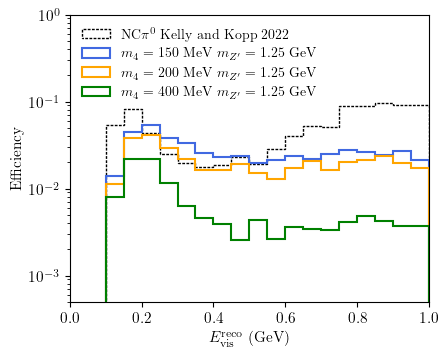

In [15]:
fig, ax = pt.std_fig()

bins = np.linspace(0.0, 1.0, 21, endpoint=True)
binc = (bins[:-1]+bins[1:])/2

kelly_bins = np.linspace(0.0, 1.0, 21, endpoint=True)
kelly_circ1_eff = np.genfromtxt(files('fastbnb.include.pi0_tools').joinpath('pi0_efficiency_circ1.dat').open())
ax.hist(kelly_circ1_eff[:,0], bins= kelly_bins, weights=kelly_circ1_eff[:,1], histtype='step', color='black', ls=(1,(2,1)), label=fr'NC$\pi^0$ Kelly and Kopp 2022')

hist_4_t, _ = np.histogram(VAR_4, bins = bins, weights = df_analysis_4['w_event_rate']/np.sum(df_analysis_4['w_event_rate']))
hist_5_t, _ = np.histogram(VAR_5, bins = bins, weights = df_analysis_5['w_event_rate']/np.sum(df_analysis_5['w_event_rate']))
hist_6_t, _ = np.histogram(VAR_6, bins = bins, weights = df_analysis_6['w_event_rate']/np.sum(df_analysis_6['w_event_rate']))
hist_4, _ = np.histogram(VAR_4, bins = bins, weights = df_analysis_4['reco_w']/np.sum(df_analysis_4['w_event_rate']))
hist_5, _ = np.histogram(VAR_5, bins = bins, weights = df_analysis_5['reco_w']/np.sum(df_analysis_5['w_event_rate']))
hist_6, _ = np.histogram(VAR_6, bins = bins, weights = df_analysis_6['reco_w']/np.sum(df_analysis_6['w_event_rate']))

eps_4 = df_analysis_4['reco_w'].sum()/df_analysis_4['w_event_rate'].sum()
eps_5 = df_analysis_5['reco_w'].sum()/df_analysis_5['w_event_rate'].sum()
eps_6 = df_analysis_6['reco_w'].sum()/df_analysis_6['w_event_rate'].sum()

_ = ax.hist(binc, bins = bins, weights=hist_4/hist_4_t, histtype='step', edgecolor='royalblue', lw=LW, label=r'$m_4 = 150$~MeV $m_{Z^\prime} = 1.25$~GeV')
_ = ax.hist(binc, bins = bins, weights=hist_5/hist_5_t, histtype='step', edgecolor='orange', lw=LW, label=r'$m_4 = 200$~MeV $m_{Z^\prime} = 1.25$~GeV')
_ = ax.hist(binc, bins = bins, weights=hist_6/hist_6_t, histtype='step', edgecolor='green', lw=LW, label=r'$m_4 = 400$~MeV $m_{Z^\prime} = 1.25$~GeV')

ax.legend(loc='upper left', ncol=1, fontsize=10)
ax.set_xlabel(r'$E_{\rm vis}^{\rm reco}$ (GeV)')
ax.set_ylabel(r'Efficiency')
ax.set_xlim(0, max(bins))
ax.set_ylim(0.5e-3, 1)
ax.set_yscale('log')

## Plotting a few cut flow distributions

We pick a specific model df_1 and plot a few kinematical variables before and after signal selection.

In [16]:
df = df_decay_1

# already selected for fiducial volume
w = df['w_event_rate'].to_numpy() 

# Smear e+ and e-
pep = fastbnb.fastmc.smear_samples(df['P_decay_ell_plus'], dn.const.m_e, exp='miniboone')
pem = fastbnb.fastmc.smear_samples(df['P_decay_ell_minus'], dn.const.m_e, exp='miniboone')

# Kinematics of interest
emax_r = np.where(pep[:,0] >= pem[:,0], pep[:,0], pem[:,0])
etot_r = pep[:,0] + pem[:,0]

# Get rid of invisible events (smearing brough E <= 0)
w[pep[:,0] < 1e-3] *= 0
w[pem[:,0] < 1e-3] *= 0

costhetaep_r = Cfv.get_cosTheta(pep)
costhetaem_r = Cfv.get_cosTheta(pem)
costhetaemax_r = np.where(pep[:,0] >= pem[:,0], costhetaep_r, costhetaem_r)

Delta_costheta_r = Cfv.get_cos_opening_angle(pem,pep)

mee_r = Cfv.inv_mass(pep+pem, pep+pem)

r_circ1 = np.sqrt( (1 - Delta_costheta_r)**2/4 + (1 - emax_r/etot_r)**2 )
r_circ0 = np.sqrt( (1 + Delta_costheta_r)**2/4 + (emax_r/etot_r)**2 )
r_diag  = 1 - 1/2*((1 + Delta_costheta_r)/2 + emax_r/etot_r)

ovl = (Delta_costheta_r > np.cos(13*np.pi/180))
asy = ((pep[:,0] < 0.03) & (pem[:,0] > 0.03)) | ((pem[:,0] < 0.03) & (pep[:,0] > 0.03))
OldCut = ovl | asy

In [17]:
f_cut_diag    = fastbnb.fastmc.get_r_cut_func(cut='diag')
f_cut_circle1 = fastbnb.fastmc.get_r_cut_func(cut='circ1')
f_cut_circle0 = fastbnb.fastmc.get_r_cut_func(cut='circ0')

In [18]:
NBINS = 50
HistWeight = w/np.sum(w)*NBINS

HistWeight_CutCirc1 = HistWeight * (r_circ1 < f_cut_circle1(etot_r))
HistWeight_CutCirc0 = HistWeight * (r_circ0 > f_cut_circle0(etot_r))
HistWeight_CutDiag  = HistWeight * (r_diag < f_cut_diag(etot_r))
HistWeight_CutMee   = HistWeight * (mee_r < fastbnb.fastmc.mee_cut_func(etot_r)) * OldCut


eff_CutCirc1 = np.sum(HistWeight_CutCirc1) / np.sum(HistWeight)
eff_CutCirc0 = np.sum(HistWeight_CutCirc0) / np.sum(HistWeight)
eff_CutDiag = np.sum(HistWeight_CutDiag) / np.sum(HistWeight)
eff_CutMee = np.sum(HistWeight_CutMee) / np.sum(HistWeight)

### Invariant mass

Text(0, 0.5, 'Events (a.u.)')

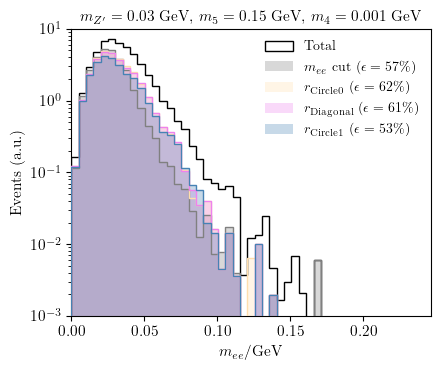

In [19]:
fig, ax = pt.std_fig()

VAR = mee_r
bins = np.linspace(0, np.max(VAR), NBINS)
ALPHA = 0.3
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)
ax.legend(loc='upper right')

ax.set_xlim(0,np.max(bins))
ax.set_ylim(1e-3,10)
ax.set_yscale('log')
ax.set_xlabel(r'$m_{ee}/$GeV')
ax.set_ylabel(r'Events (a.u.)')

### Total energy

Text(0, 0.5, 'Events (a.u.)')

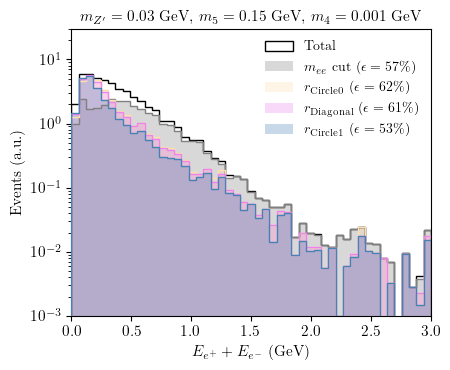

In [20]:
fig, ax = pt.std_fig()

VAR = etot_r
bins = np.linspace(0, 3, NBINS)
ALPHA = 0.3
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)

ax.legend(loc='upper right')
ax.set_xlim(0, max(bins))
ax.set_ylim(1e-3,30)
ax.set_yscale('log')
ax.set_xlabel(r'$E_{e^+} + E_{e^-}$ (GeV)')
ax.set_ylabel(r'Events (a.u.)')

### Emax/Etot

Text(0, 0.5, 'Events (a.u.)')

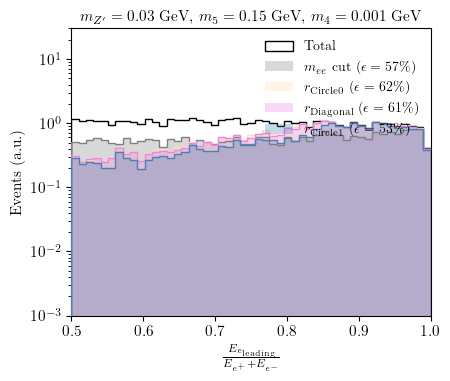

In [21]:
fig, ax = pt.std_fig()
VAR = emax_r/etot_r
bins = np.linspace(0.5, np.max(VAR), NBINS)
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)

ax.legend(loc='upper right', ncol=1, fontsize=10) 
ax.set_xlim(0.5, 1)
ax.set_ylim(1e-3, 30)
ax.set_yscale('log')
ax.set_xlabel(r'$\frac{E_{e_{\rm leading}}}{E_{e^+} + E_{e^-}}$')
ax.set_ylabel(r'Events (a.u.)')

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_89555/2401580745.py:2: RuntimeWarning: invalid value encountered in divide
  VAR = (np.sqrt(pep[:,0]**2 - dn.const.m_e**2) - np.sqrt(pem[:,0]**2 - dn.const.m_e**2))/(np.sqrt(pep[:,0]**2 - dn.const.m_e**2) + np.sqrt(pem[:,0]**2 - dn.const.m_e**2))


Text(0, 0.5, 'Events (a.u.)')

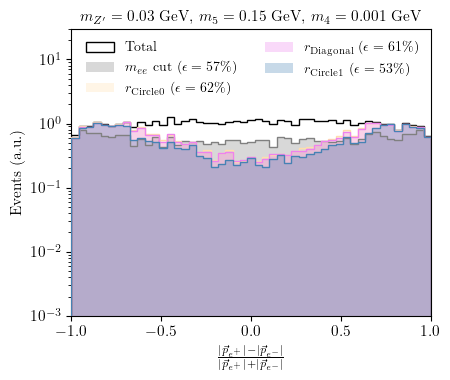

In [22]:
fig, ax = pt.std_fig()
VAR = (np.sqrt(pep[:,0]**2 - dn.const.m_e**2) - np.sqrt(pem[:,0]**2 - dn.const.m_e**2))/(np.sqrt(pep[:,0]**2 - dn.const.m_e**2) + np.sqrt(pem[:,0]**2 - dn.const.m_e**2))
bins = np.linspace(-1, 1, NBINS)
ALPHA = 0.3
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)

ax.legend(loc='upper right', ncol=2, fontsize=10) 

ax.set_xlim(-1,1)
ax.set_ylim(1e-3,30)
ax.set_yscale('log')
ax.set_xlabel(r'$\frac{|\vec{p}_{e^+}| - |\vec{p}_{e^-}|}{|\vec{p}_{e^+}| + |\vec{p}_{e^-}|}$')
ax.set_ylabel(r'Events (a.u.)')

### Opening angle

Text(0, 0.5, 'Events (a.u.)')

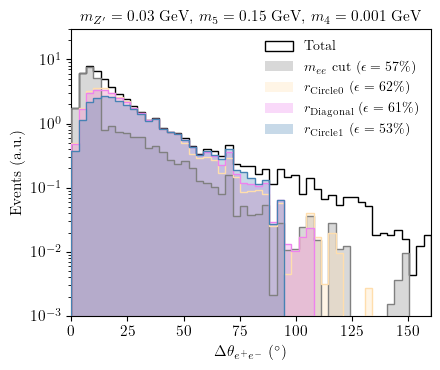

In [23]:
fig, ax = pt.std_fig()

VAR = np.arccos(Delta_costheta_r)*180/np.pi
bins = np.linspace(0, 160, NBINS)
ALPHA = 0.3
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)

ax.legend(loc='upper right')
ax.set_xlim(0, max(bins))
ax.set_ylim(1e-3,30)
ax.set_yscale('log')

ax.set_xlabel(r'$\Delta \theta_{e^+e^-}$ $({}^\circ)$')
ax.set_ylabel(r'Events (a.u.)')

### Angle of the leading electron 

Text(0, 0.5, 'Events (a.u.)')

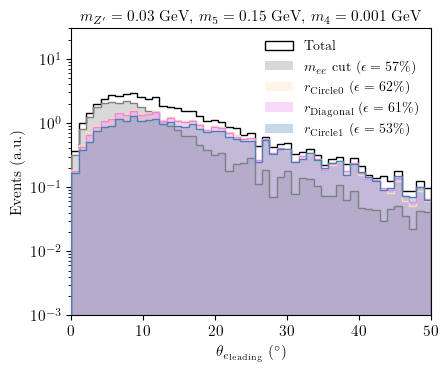

In [24]:
fig, ax = pt.std_fig()

VAR = np.arccos(costhetaemax_r)*180/np.pi
bins = np.linspace(0, 50, NBINS)

ALPHA = 0.3
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)

ax.legend(loc='upper right')
ax.set_ylim(1e-3,30)
ax.set_yscale('log')
ax.set_xlim(0, max(bins))
ax.set_xlabel(r'$\theta_{e_{\rm leading}}$ $({}^\circ)$')
ax.set_ylabel(r'Events (a.u.)')

## Exploring a π0-like sample

Instead of single shower CCQE events, we can plot the invariant mass for events that do not pass the CCQE criteria due to the large e+e- separation angles.

In [25]:
pi0_ovl = (Delta_costheta_r > np.cos(13*np.pi/180))
pi0_asy = (pep[:,0] > 0.03) & (pem[:,0] > 0.03)
pi0_OldCut = pi0_ovl | pi0_asy

pi0_HistWeight_CutCirc1 = HistWeight * (r_circ1 > f_cut_circle1(etot_r))
pi0_HistWeight_CutCirc0 = HistWeight * (r_circ0 < f_cut_circle0(etot_r))
pi0_HistWeight_CutDiag = HistWeight * (r_diag > f_cut_diag(etot_r))
pi0_HistWeight_CutMee = HistWeight * pi0_OldCut


pi0_eff_CutCirc1 = np.sum(pi0_HistWeight_CutCirc1) / np.sum(HistWeight)
pi0_eff_CutCirc0 = np.sum(pi0_HistWeight_CutCirc0) / np.sum(HistWeight)
pi0_eff_CutDiag = np.sum(pi0_HistWeight_CutDiag) / np.sum(HistWeight)
pi0_eff_CutMee = np.sum(pi0_HistWeight_CutMee) / np.sum(HistWeight)

Text(0, 0.5, 'Events (a.u.)')

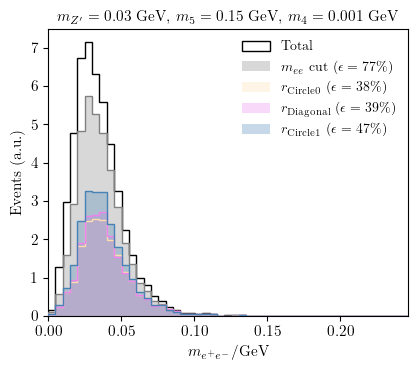

In [26]:
fig, ax = pt.std_fig()

VAR = mee_r
bins = np.linspace(0, np.max(mee_r), NBINS)
ALPHA = 0.3
LW = 1.

_ = ax.hist(VAR, bins=bins, histtype='step', edgecolor='black', weights=HistWeight, zorder=2, density=False, label=r'Total')

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'grey', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = pi0_HistWeight_CutMee, label=r'$m_{ee}$ cut'+fr' $(\epsilon = {pi0_eff_CutMee*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='grey', lw=LW, weights = pi0_HistWeight_CutMee, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'navajowhite', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = pi0_HistWeight_CutCirc0, label=r'$r_{\rm Circle 0}$'+fr' $(\epsilon = {pi0_eff_CutCirc0*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='navajowhite', lw=LW, weights = pi0_HistWeight_CutCirc0, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'violet', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = pi0_HistWeight_CutDiag, label=r'$r_{\rm Diagonal}$'+fr' $(\epsilon = {pi0_eff_CutDiag*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='violet', lw=LW, weights=pi0_HistWeight_CutDiag, zorder=3)

_ = ax.hist(VAR, bins = bins, histtype = 'stepfilled', facecolor = 'steelblue', edgecolor = 'black', lw = 0.0, alpha = ALPHA, zorder = 1, weights = pi0_HistWeight_CutCirc1, label=r'$r_{\rm Circle 1}$'+fr' $(\epsilon = {pi0_eff_CutCirc1*100:.0f}\%$)')
_ = ax.hist(VAR, bins = bins, histtype = 'step', facecolor = 'None', edgecolor='steelblue', lw=LW, weights = pi0_HistWeight_CutCirc1, zorder=3)

ax.set_title(rf'$m_{{Z^\prime}} = {df.attrs["model"].mzprime}$ GeV, $m_5 = {df.attrs["model"].m5}$ GeV, $m_4 = {df.attrs["model"].m4}$ GeV', fontsize=11)

ax.legend(loc='upper right')
ax.set_xlim(0, max(bins))

ax.set_xlabel(r'$m_{e^+e^-}$/GeV')
ax.set_ylabel(r'Events (a.u.)')

### Look at the MiniBooNE-provided single gamma/electron efficiencies

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_92130/4102588853.py:4: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  enu_c, eff, err_eff = np.genfromtxt( open_text("fastbnb.include.miniboone_eff", 'eg_effs.dat') ,unpack=True)


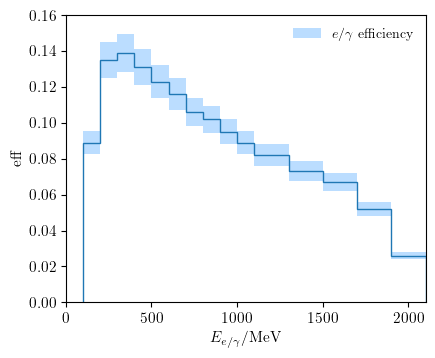

In [10]:
from importlib.resources import open_text

fig,ax = pt.std_fig()
enu_c, eff, err_eff = np.genfromtxt( open_text("fastbnb.include.miniboone_eff", 'eg_effs.dat') ,unpack=True)
enu_w = np.array([100]*11 + [200]*5)
eff_func = interpolate.interp1d(enu_c, eff, fill_value=(eff[0],eff[-1]), bounds_error=False, kind='nearest')


kwargs={'facecolor': 'dodgerblue', 'edgecolor': 'None'}
# pt2.data_plot(ax, enu_c, enu_w, eff, err_eff/2, err_eff/2, label=r'$e/\gamma$ efficiency')
fastbnb.plot_tools.errorband_plot(ax, enu_c, enu_w, eff, err_eff/2, err_eff/2, label=r'$e/\gamma$ efficiency', **kwargs)
ax.legend(loc='upper right', )

ax.set_ylim(0,0.160)
ax.set_xlim(0,2100)
ax.set_xlabel(r"$E_{e/\gamma}/$MeV")
ax.set_ylabel(r"eff")

pt.std_savefig(fig, 'plots/miniboone_effs.pdf')